In [1]:
%matplotlib inline
%load_ext Cython

#http://people.duke.edu/~ccc14/sta-663-2016/18D_Cython.html


import matplotlib.pylab as plt
import random
import numpy as np

In [2]:
def printMatrix(matrix):
    for line in matrix:
        print("\t".join(map(str,line)))

def make_mat(size):
    mat = []
    for i in range(0,size):
        temp = []
        for j in range(0,size):
            temp.append(random.random()*10*random.random())
        mat.append(temp)
    return mat

In [3]:
def mat_mul_py(A, B):
    C = [[0 for i in range(len(A))] for j in range(len(A))]
    for i in range(len(A)):
        for j in range(len(A)):
            for k in range(len(A)):
                C[i][j] += A[i][k] * B[k][j]
    return C

In [4]:
A = make_mat(340)
B = make_mat(340)

In [5]:
%%time
x = mat_mul_py(A,B)

CPU times: user 9.82 s, sys: 24.7 ms, total: 9.85 s
Wall time: 9.86 s


In [6]:
%%cython

def mat_mul_cy(A, B):
    C = [[0 for i in range(len(A))] for j in range(len(A))]
    for i in range(len(A)):
        for j in range(len(A)):
            for k in range(len(A)):
                C[i][j] += A[i][k] * B[k][j]
    return C

In [7]:
%%time
x = mat_mul_cy(A,B)

CPU times: user 3.41 s, sys: 36 ms, total: 3.44 s
Wall time: 3.44 s


In [8]:
%%cython -a 

cimport cython
from cython.parallel import prange
from cython.view cimport array as cvarray

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def mat_mul_cy_fast(float[:,:] A, float[:,:] B, float[:,:] C):
    cdef int n = A.shape[0]
    cdef int i,j,k
    #for i in prange(n, nogil=True):
    for i in range(n):
        for k in range(n):
            C[i,j] = 0.0
            for j in range(n):
                C[i,j] += (A[i,k] * B[k,j])

In [9]:
%%time
size = 20
A = np.random.random((size,size)).astype(np.float32)
B = np.random.random((size,size)).astype(np.float32)
C = np.zeros((A.shape[0], A.shape[1])).astype(np.float32)

CPU times: user 3.07 ms, sys: 1.4 ms, total: 4.47 ms
Wall time: 3.78 ms


In [10]:
%%time
mat_mul_cy_fast(A,B,C)

CPU times: user 33 µs, sys: 15 µs, total: 48 µs
Wall time: 51 µs


In [11]:
%%time
C = A * B

CPU times: user 26 µs, sys: 7 µs, total: 33 µs
Wall time: 37 µs


In [69]:
%%cython -a

def mandel(x, y, max_iters):
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if z.real*z.real + z.imag*z.imag >= 4:
            return i
    return max_iters

def create_fractal(xmin, xmax, ymin, ymax, image, iters):
    height, width = image.shape

    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height

    for x in range(width):
        real = xmin + x*pixel_size_x
        for y in range(height):
            imag = ymin + y*pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x]  = color
            

In [42]:
gimage = np.zeros((1024, 1536), dtype=np.uint8)
xmin, xmax, ymin, ymax = [-2.0, 1.0, -1.0, 1.0]
iters = 100

In [43]:
%%time
create_fractal(xmin, xmax, ymin, ymax, gimage, iters)

CPU times: user 11.4 s, sys: 74.9 ms, total: 11.5 s
Wall time: 11.5 s


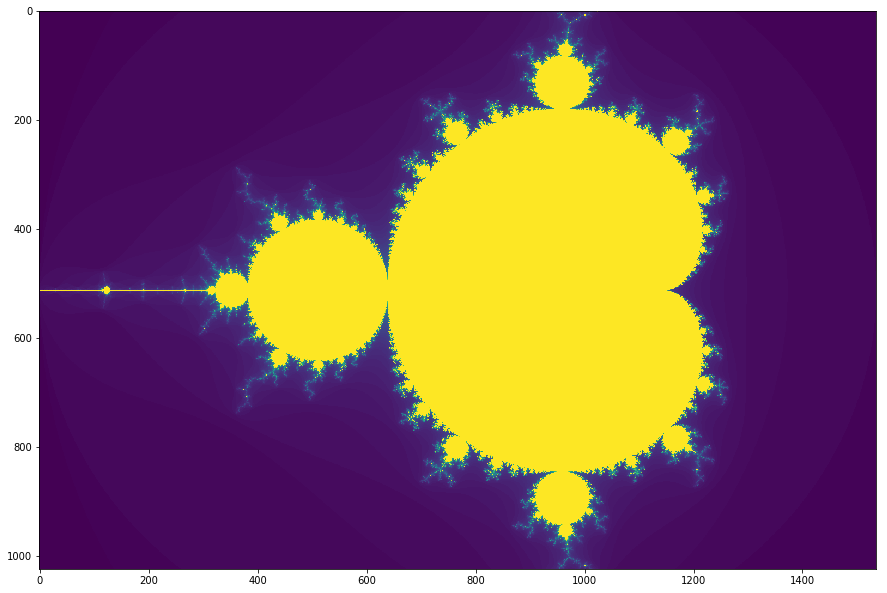

In [44]:
plt.figure(figsize=(15,15))
plt.grid(False)
plt.imshow(gimage, cmap='viridis')
plt.show()

In [34]:
%%cython -a

cimport cython

cdef extern from "complex.h":
    double cabs(double complex)

# color function for point at (x, y)
cdef unsigned int mandel_cython(float x, float y, int max_iters):
    cdef double complex c, z
    c = x + y*1j
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if cabs(z) >= 2:
            return i
    return max_iters

@cython.cdivision(True)
def create_fractal_cython(float xmin, float xmax, float ymin, float ymax, unsigned int[:, :] image, int iters):

    cdef int x, y
    cdef int height, width
    cdef double pixel_size_x, pixel_size_y
    cdef double real, imag
    cdef unsigned int color

    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height

    for x in range(width):
        real = xmin + x*pixel_size_x
        for y in range(height):
            imag = ymin + y*pixel_size_y
            color = mandel_cython(real, imag, iters)
            image[y, x]  = color

In [66]:
gimage = np.zeros((1080, 1920), dtype=np.uint32)
xmin, xmax, ymin, ymax = [-2.0, 1.0, -1.0, 1.0]
iters = 50

In [67]:
%%time
create_fractal_cython(xmin, xmax, ymin, ymax, gimage, iters)

CPU times: user 258 ms, sys: 4.87 ms, total: 262 ms
Wall time: 262 ms


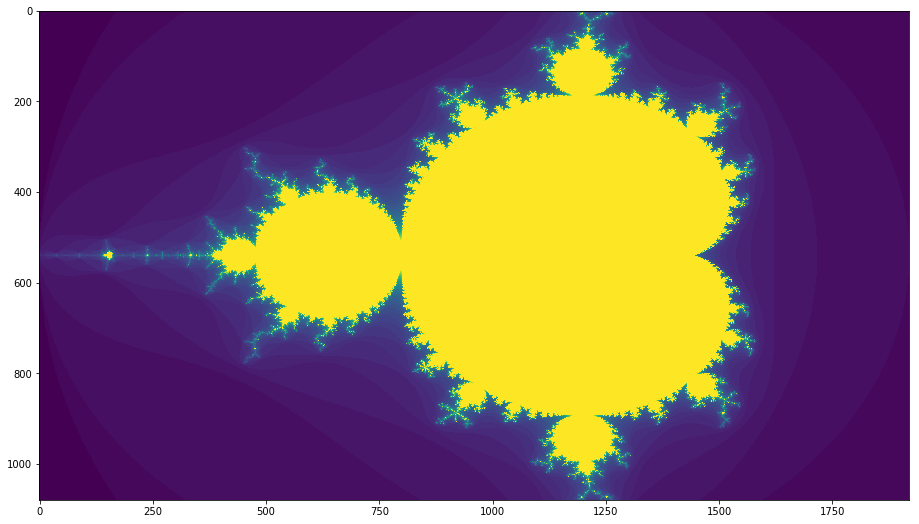

In [68]:
plt.figure(figsize=(16,9))
plt.grid(False)
plt.imshow(gimage, cmap='viridis')
plt.show()